<h2> Forest Fire Imaging Predictive Model </h2>
<p>
    The purpose of this notebook is to create a predictive model using Keras with Tensorflow for detecting forest fires in images. This will be accomplished by firstly organizing, preprocessing, and dividing a dataset of several hundred images marked by:
</p>

<blockquote>
    Fire: There is fire present in the photo <br>
    NoFire: There is not a fire present in the photo
</blockquote> 

<p>
    From here, we will build, compile, and fit a sequential model to our dataset with the goal of accurately predicting the presence or abscence of fire. We will then provide data visualizations to better understand the accuracy of our model and develop the ability to improve the model.
</p>

In [316]:
"""
Refer to "ForestFireDataAnalysis.ipynb" for data visualization and "ForestFirePredictiveModel" for model
based on previous data.
The dataset used in this file is from another paper and is to be considered seperately from the previous work.

Purpose: create a predictive model for detecting forest fires using a sample of training / testing images
"""

# Data handling
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt

In [317]:
# Access directory path for images
directory_path = "/Users/sasha/Desktop/ForestFireDataProject/Forest Fire Dataset/Raw_Image_Data"


In [318]:
# Machine learning libraries
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Parameters for model indicating the amount of images to feed per iteration, image width / height, and random seed
batch_size = 32
img_height = 250
img_width = 250
seed = 123

<h2> Data Organization</h2>
<p>
    Our images have been preprocessed and put in the following directory structure:
</p>
<blockquote>
    Forest Fire Dataset/ <br>
    &nbsp &nbsp &nbsp &nbsp Testing/<br>
    &nbsp &nbsp &nbsp &nbsp Training/<br>
    &nbsp &nbsp &nbsp &nbsp Raw_Image_Data/<br>
    &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp Fire_Images/ <br>
    &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp No_Fire_Images/
</blockquote>
<p>
    All of our images are 250x250 pixels with 3 alpha channels. The goal with the following code is to divide the training data to make up 80% of our dataset and the testing data to make up the remaining 20%.
</p>

In [319]:
# Divide data into 80% for training and 20% for testing
# Organize by file structure into seperate classes
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory_path,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  directory_path,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)


Found 1900 files belonging to 2 classes.
Using 1520 files for training.
Found 1900 files belonging to 2 classes.
Using 380 files for validation.


<h2> Imaging </h2>
<p>
    We will use the Pillow library to visualize our dataset. Our goal in the following code is to: <br>
    &nbsp &nbsp &nbsp &nbsp 1. Visualize the data and notice the distinctions between fire and nofire images <br>
    &nbsp &nbsp &nbsp &nbsp 2. Notice the seed variable restricting the images to appear in strictly the same order <br>
</p>

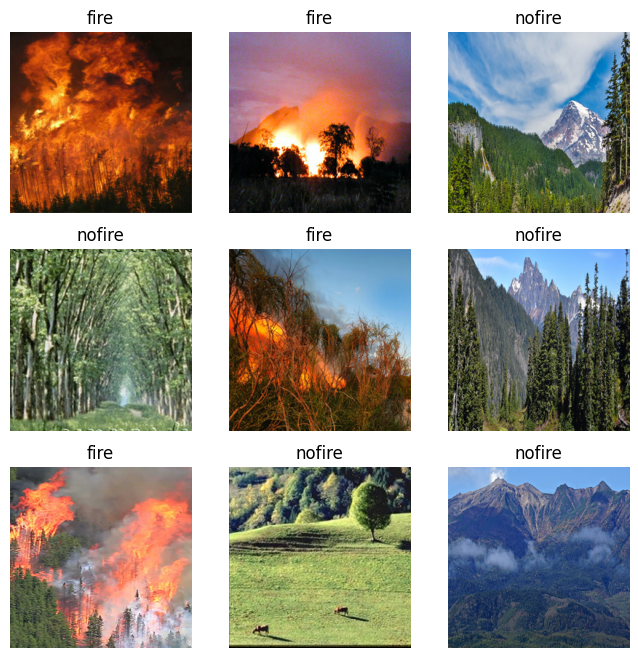

In [422]:
# Image handling library (Pillow)
from PIL import Image

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

<h2> Building Our Model </h2>
<p> 
    Now that our data is preprocessed and organized into testing and training splits, we will begin constructing our model. We are using a simple sequential model for this task as we do not have multiple exclusively dependant inputs. We will perform the following:
</p>
<ol>
    <li>
        Firstly, we will utilize Tensorflow AUTOTUNE for dynamic tuning of data at runtime. This will lead to increased performance while cacheing and prefetching data.
    </li>
    <li>
        Now it is time to construct our model. As stated before, we will use a sequential (linear) model with the following layers:
        <ul>
            <li>Rescaling Layer: rescales RGB values [1,255] to [0,1] for easier processing. This is a standard procedure for most machine learning models  </li>
            <li>3 Convolution Layers: augments the output imagery using a 3x3 matrix with standard strictly-positive linear function   </li>
            <li>3 MaxPooling Layers: intensifies results found in convolution layers by allowing greater contrast between pixels. This leads to the model performing better as it is able to identify large differences easier.  </li>
            <li>Flatten Layer: converts multi-dimensional array into a one-dimensional array.  </li>
            <li>Dense Layer: a regular model layer.  </li>
            <li>Dense Output Layer: 2 outputs each representing the chance of fire or no_fire appearing in the image  </li>
        </ul>
    </li>
    <li>
        Now that our model is built, we will compile it. For compiling, we will use the standard Adam optimizer with a standard Crossentropy loss function. Finally, we will measure our models level of validity using an accuracy metric.
    </li>
</ol>

In [321]:
# Configure dataset for performance with cacheing and prefetching data
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [322]:
# Model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Rescale [1,255] range of RGB values to [0,1]
  layers.Conv2D(16, 3, padding='same', activation='relu'), # Apply standard matrix to augment image using rectified linear unit algorithm
  layers.MaxPooling2D(), # For identifying sharp contrasts in fire against background
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(), # Flatten multi-dimensional array into a one-dimensional array
  layers.Dense(128, activation='relu'), # Regular layer
  layers.Dense(len(class_names)) # 2 outputs (chance of fire or no_fire)
])

In [323]:
# Compile model with regular Adam optimizer - pruning for accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [324]:
# Brief model summary (before training begins)
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_17 (Rescaling)    (None, 250, 250, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 125, 125, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 62, 62, 64)      

<h2> Training Our Model </h2>
<p> 
    Our model is fully constructed - it is time to begin training it. For training our model, we will simply utilize our training and testing datasets that we divide earlier. We will utilize 10 epochs as an initial training amount (which can be adjusted if necessary), where an epoch is defined as:
</p>

<blockquote> 
    Epoch: one complete pass of the training data set through the algorithm, forwards and back.
</blockquote>

<p>
    This will provide us with our first model!
</p>

In [325]:
# Train model for 10 epochs using 
epochs=10
model_history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
48/48 [==============================] - 14s 272ms/step - loss: 0.2564 - accuracy: 0.8974 - val_loss: 0.1890 - val_accuracy: 0.9263
Epoch 2/10
48/48 [==============================] - 13s 262ms/step - loss: 0.1281 - accuracy: 0.9572 - val_loss: 0.1723 - val_accuracy: 0.9421
Epoch 3/10
48/48 [==============================] - 12s 257ms/step - loss: 0.1355 - accuracy: 0.9579 - val_loss: 0.1556 - val_accuracy: 0.9421
Epoch 4/10
48/48 [==============================] - 12s 257ms/step - loss: 0.1011 - accuracy: 0.9671 - val_loss: 0.1546 - val_accuracy: 0.9500
Epoch 5/10
48/48 [==============================] - 12s 258ms/step - loss: 0.0748 - accuracy: 0.9757 - val_loss: 0.1575 - val_accuracy: 0.9421
Epoch 6/10
48/48 [==============================] - 12s 263ms/step - loss: 0.0616 - accuracy: 0.9822 - val_loss: 0.2008 - val_accuracy: 0.9395
Epoch 7/10
48/48 [==============================] - 12s 260ms/step - loss: 0.0443 - accuracy: 0.9875 - val_loss: 0.2001 - val_accuracy: 0.9421

<h2> Visualizing Our Model </h2>
<p> 
    Our model has now trained with the following results:
</p>

<ul> 
    <li>
        Training Data:
        <ul>
            <li>
                Loss (1%): the purpose of loss functions is to compute the quantity that a model should seek to minimize during training. A lower loss value is a meaningful statistic.
            </li>
            <li>
                Accuracy (99.4%): the accuracy parameter shows how well the model is performing against the training dataset.
            </li>
        </ul>
    </li>
    <li>
        Validation / Testing Data:
        <ul>
            <li>
                Loss (33%): the purpose of loss functions is to compute the quantity that a model should seek to minimize during training. A lower loss value is a meaningful statistic. In our validation data, our loss function is growing, which we will address next.
            </li>
            <li>
                Accuracy (92.8%): the accuracy parameter shows how well the model is performing against the testing dataset.
            </li>
        </ul>
    </li>
</ul>

In [356]:
# Visualize model data function
def visualize_model_history(model_history):
    accuracy = model_history.history['accuracy'] # accuracy of training
    testing_accuracy = model_history.history['val_accuracy'] # testing data accuracy
    
    loss = model_history.history['loss'] # prediction error
    testing_loss = model_history.history['val_loss'] # testing data prediction error
    
    epochs_range = range(epochs)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy', color='red')
    plt.plot(epochs_range, testing_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title('Training vs. Testing Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='red')
    plt.plot(epochs_range, testing_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.title('Training vs. Testing Loss')
    plt.show()


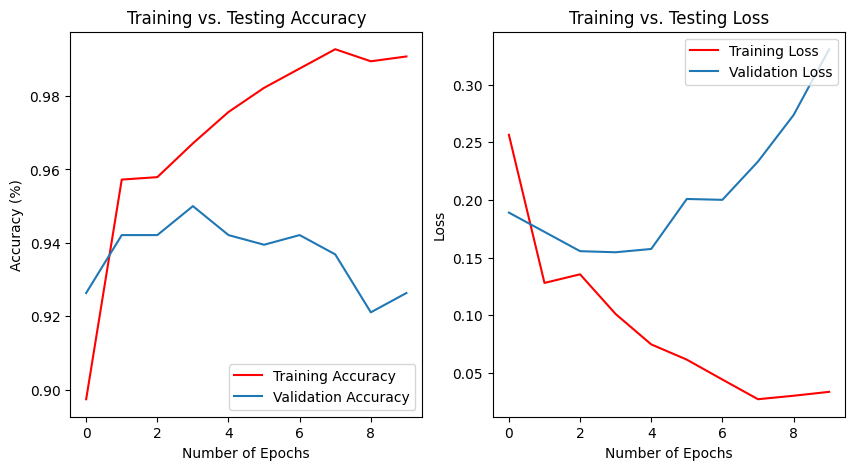

In [357]:
# Visualize data
visualize_model_history(model_history)

<h2> Model Analysis </h2>
<p> 
    Our model is performing quite well (92% on the testing dataset), but the very different curves in both accuracy and loss indicate that our model is overfitting. Overfitting is defined as:
</p>
<blockquote>
    Overfitting: occurs when a model cannot generalize its learning to other data - only performs at high accuracy with training or testing data.
</blockquote>

<p>
    To fix this, we will incorporate <b>data augmentation</b> and <b>dropout</b> to correct for this overfitting error and increase the general performance of our model for further testing.
</p>

<h2> Data Augmentation </h2>
<p> 
    Overfitting can occur due to low amounts of test data. To correct for this, we can use data augmentation to generate new data to feed our model. This procedurally generated data is created by augmenting the images by random transformations. This will provide "mostly-realistic" images that will help our model understand other aspects of our images. To do this, we will create an additional sequential model that we will prepend to our existing model. This model will contain the following layers:
</p>
<ul>
    <li>
        RandomFlip Layer: flips an image (in this case, along the horizontal axis). This is our first transformation to generate more data without augmentating our image too much.
    </li>
    <li>
        RandomRotation Layer: randomly rotates individual pixels by a scale of 0.1 (represented as a fraction of 2&pi;). This is our second transformation.
    </li>
    <li>
        RandomZoom Layer: randomly zooms in along each axis by a scale of 0.1. This is our final transformation towards generating new data
    </li>
</ul>

In [359]:
# Data Augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

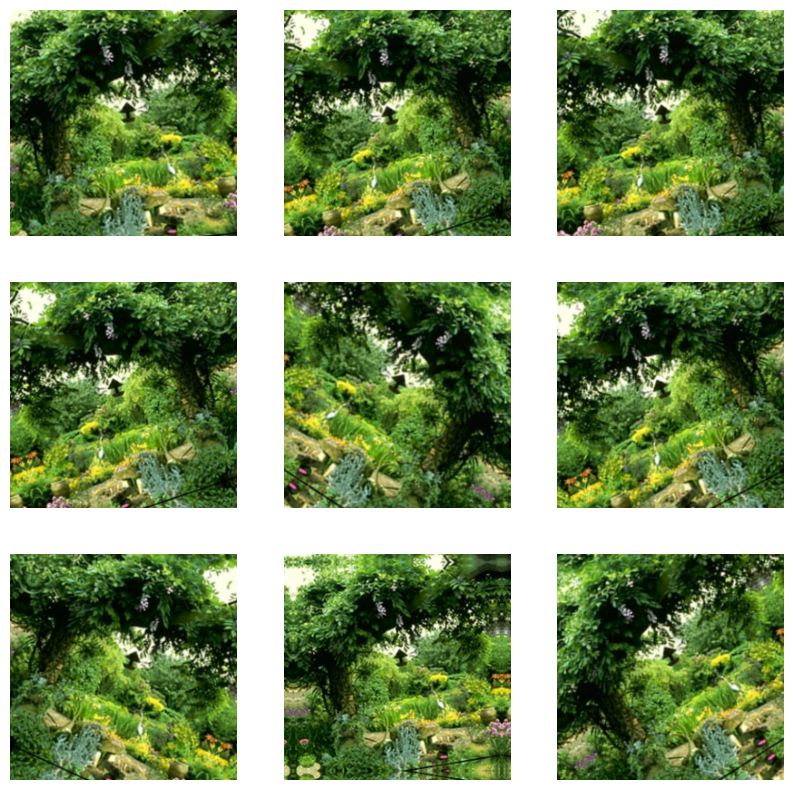

In [360]:
# Visualizing data augmentations
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(4):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

<h2> Dropout </h2>
<p> 
    To further counter overfitting, we will incorporate a simple dropout layer to our model. Dropout simply drops a percentage of output units from the layer it is applied to. This counteracts overfitting as it removes the consistency of your dataset - effectively it allows the model to not just rely on prior experience with the data, but to consider it as a new image. This is in a way, a form of data augmentation.
</p>
<p>
    In the next few cells, we will rebuild, recompile, and refit our model the same way we did before, but with the additional dropout layer and prepending our data augmentation sequential model.
</p>


In [361]:
# Dropout amount (20%)
dropout_percentage = 0.2

# Model
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Rescale [1,255] range of RGB values to [0,1]
  layers.Conv2D(16, 3, padding='same', activation='relu'), # Apply standard matrix to augment image using rectified linear unit algorithm
  layers.MaxPooling2D(), # For identifying sharp contrasts in fire against background
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(dropout_percentage),
  layers.Flatten(), # Flatten multi-dimensional array into a one-dimensional array
  layers.Dense(128, activation='relu'), # Regular layer
  layers.Dense(len(class_names)) # 2 outputs (chance of fire or no_fire)
])

In [362]:
# Compiling
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Summary
model.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 250, 250, 3)       0         
                                                                 
 rescaling_18 (Rescaling)    (None, 250, 250, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 125, 125, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                               

In [363]:
# Increased number of epochs to better train our model (will take longer)
epochs = 15
revised_model_history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
48/48 [==============================] - 14s 290ms/step - loss: 0.4041 - accuracy: 0.8671 - val_loss: 0.1797 - val_accuracy: 0.9289
Epoch 2/15
48/48 [==============================] - 14s 287ms/step - loss: 0.1784 - accuracy: 0.9414 - val_loss: 0.1930 - val_accuracy: 0.9132
Epoch 3/15
48/48 [==============================] - 14s 284ms/step - loss: 0.1263 - accuracy: 0.9645 - val_loss: 0.1692 - val_accuracy: 0.9421
Epoch 4/15
48/48 [==============================] - 14s 283ms/step - loss: 0.1153 - accuracy: 0.9651 - val_loss: 0.1567 - val_accuracy: 0.9447
Epoch 5/15
48/48 [==============================] - 14s 286ms/step - loss: 0.1015 - accuracy: 0.9612 - val_loss: 0.2288 - val_accuracy: 0.9368
Epoch 6/15
48/48 [==============================] - 14s 288ms/step - loss: 0.0954 - accuracy: 0.9671 - val_loss: 0.1902 - val_accuracy: 0.9395
Epoch 7/15
48/48 [==============================] - 14s 292ms/step - loss: 0.0965 - accuracy: 0.9658 - val_loss: 0.1659 - val_accuracy: 0.9421

<h2> Revisualizing Our Model </h2>
<p> 
    Now that we have adapted our model and incorported data augmentation and dropout, we can revisualize the loss and accuracy functions of our models performance using our <code>visualize_model_history()</code> function.
</p>


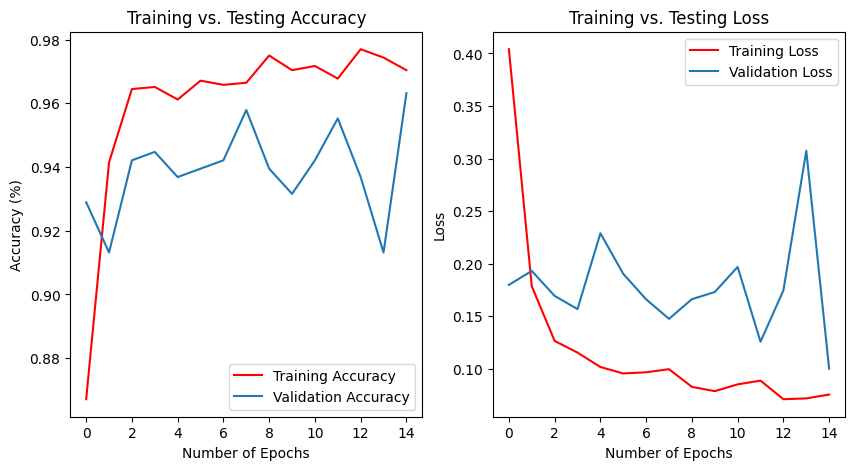

In [364]:
# Visualize model data
visualize_model_history(revised_model_history)

<h2> Repeated Model Analysis </h2>
<p> 
    As we can see, our models training accuracy and loss functions now more accurately follow the trend of the testing accuracy and loss functions. This indicates to us that we have successfully made a significant dent in our model's overfitting problem. Overfitting will always be a problem, but we have heavily reduced it.
</p>

<h2> Unit Testing </h2>
<p> 
    To test our model's applications to unseen data and finish off this project, I sourced several images of forest fires from the internet to feed our model. We can use these results to see the practical accuracy and confidence of the model.
</p>

In [419]:
# Source images 
# Fire
unit_test_fire_images = ["https://news.cgtn.com/news/2023-06-29/Canada-s-wildfires-burn-8-million-hectares-of-land-worst-on-record-1l1REmokZ1K/img/85f9f9e977e34d19ab4fa062467dca24/85f9f9e977e34d19ab4fa062467dca24-250.png",
                         "https://cdn.labmanager.com/assets/articleNo/29892/aImg/53706/wildfires-in-2021-emitted-a-record-breaking-amount-of-carbon-dioxide-t.jpg",
                         "https://fernie.com/files/2015/07/BC-Wildfire-250x250.png"
                        ]

unit_test_nofire_images = ["https://cdn.labmanager.com/assets/articleNo/26168/aImg/48277/russian-forests-are-crucial-to-global-climate-mitigation-t.jpg",
                           "https://www.shutterstock.com/image-photo/small-forest-stream-green-hazel-250nw-421847080.jpg",
                           "https://www.northumberland.ca/en/discovering-and-exploring/resources/Images/Forest-trail-sm.JPG"
                          ]

In [420]:
import random
import string

# Number of unit tests performed
unit_tests_performed = 0

def unit_test_single_image(url, model, expected_output):

    global unit_tests_performed 

    random_file_name = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(10))
    path = tf.keras.utils.get_file(random_file_name, origin=url)

    img = tf.keras.utils.load_img(
        path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) 
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    prediction_label = class_names[np.argmax(score)]
    
    print(
        "[ UNIT TEST: {} ] This image belongs to {} with an estimated {:.2f} percent confidence. [{}]"
        .format(unit_tests_performed, class_names[np.argmax(score)], 100 * np.max(score),
                "CORRECT" if (prediction_label == "fire" and expected_output) or 
                (prediction_label == "nofire" and not expected_output) else "INCORRECT")
    )
    
    unit_tests_performed += 1


In [421]:
for url in unit_test_fire_images:
    unit_test_single_image(url, model, True)
    print()

for url in unit_test_nofire_images:
    unit_test_single_image(url, model, False)
    print()

1/1 [==============================] - 0s 16ms/step
[ UNIT TEST: 0 ] This image most likely belongs to fire with a 99.30 percent confidence. [CORRECT]

1/1 [==============================] - 0s 11ms/step
[ UNIT TEST: 1 ] This image most likely belongs to fire with a 64.17 percent confidence. [CORRECT]

1/1 [==============================] - 0s 15ms/step
[ UNIT TEST: 2 ] This image most likely belongs to fire with a 99.28 percent confidence. [CORRECT]

1/1 [==============================] - 0s 11ms/step
[ UNIT TEST: 3 ] This image most likely belongs to nofire with a 99.93 percent confidence. [CORRECT]

1/1 [==============================] - 0s 16ms/step
[ UNIT TEST: 4 ] This image most likely belongs to nofire with a 100.00 percent confidence. [CORRECT]

1/1 [==============================] - 0s 15ms/step
[ UNIT TEST: 5 ] This image most likely belongs to nofire with a 100.00 percent confidence. [CORRECT]

